# US Monthly CO2 Data

In [1]:
# imports
import pandas as pd
import numpy as np
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
# getting the US monthly co2 data
df = pd.read_csv('us_monthly_co2_data.csv')

In [3]:
df.head() # check_yo_head

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CKTCEUS,197301,109.552,1,"Coal, Including Coal Coke Net Imports, CO2 Emi...",Million Metric Tons of Carbon Dioxide
1,CKTCEUS,197302,98.833,1,"Coal, Including Coal Coke Net Imports, CO2 Emi...",Million Metric Tons of Carbon Dioxide
2,CKTCEUS,197303,98.483,1,"Coal, Including Coal Coke Net Imports, CO2 Emi...",Million Metric Tons of Carbon Dioxide
3,CKTCEUS,197304,94.150,1,"Coal, Including Coal Coke Net Imports, CO2 Emi...",Million Metric Tons of Carbon Dioxide
4,CKTCEUS,197305,95.424,1,"Coal, Including Coal Coke Net Imports, CO2 Emi...",Million Metric Tons of Carbon Dioxide


### After taking a look at the data:
- There is a '13' month which is a sum for the year but will need to be dropped
- I have a date column 'YYYYMM' but will need to format it for readability
- The 'Value' is my CO2 measurement
- The remaining columns are not needed but worth noting in decribing the data

# Prepare

In [4]:
# this is setting the 'YYYYMM' column as a string, 
# going to the end of the value then back two and removing any 13 value
df = df[df.YYYYMM.astype(str).str[-2:] != '13']

In [5]:
# Dropping columns that are not needed at this time
df = df.drop(['MSN', 'Column_Order', 'Description', 'Unit'], axis = 1)

In [6]:
# renaming the remaining columns for readability
df.rename(columns={'YYYYMM':'date', 'Value':'co2'}, inplace=True)

In [7]:
df.head() # check_yo_head

,date,co2
0,197301,109.552
1,197302,98.833
2,197303,98.483
3,197304,94.150
4,197305,95.424


In [8]:
# taking a look at the end of the data to see what year it stops at
df.tail()

,date,co2
8815,202102,415.513
8816,202103,398.802
8817,202104,366.332
8818,202105,376.347
8819,202106,403.179


In [9]:
# looking at the info to see the Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8148 entries, 0 to 8819
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8148 non-null   int64  
 1   co2     8148 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 191.0 KB


In [10]:
# setting the date column to a string in order to apply a lambda function
df.date = df.date.astype(str)

In [11]:
# using a lambda function to split apart the date values to use for datetime
df.date = df.date.apply(lambda x: x[:4] + "-" + x[4:] + "-" + '01')

In [12]:
df.head() # check_yo_head

,date,co2
0,1973-01-01,109.552
1,1973-02-01,98.833
2,1973-03-01,98.483
3,1973-04-01,94.150
4,1973-05-01,95.424


In [13]:
# setting the date column to a datetime format
df.date = pd.to_datetime(df.date, format = ('%Y-%m-%d'))


In [14]:
df.head() # check_yo_head

,date,co2
0,1973-01-01,109.552
1,1973-02-01,98.833
2,1973-03-01,98.483
3,1973-04-01,94.150
4,1973-05-01,95.424


In [15]:
# looking at the end of the data
df.tail()

,date,co2
8815,2021-02-01,415.513
8816,2021-03-01,398.802
8817,2021-04-01,366.332
8818,2021-05-01,376.347
8819,2021-06-01,403.179


In [16]:
# adding 'year' and 'month' columns to help read the data
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

df.head() # check_yo_head

,date,co2,year,month
0,1973-01-01,109.552,1973,1
1,1973-02-01,98.833,1973,2
2,1973-03-01,98.483,1973,3
3,1973-04-01,94.150,1973,4
4,1973-05-01,95.424,1973,5


In [17]:
# looking at the end of the data again
df.tail()

,date,co2,year,month
8815,2021-02-01,415.513,2021,2
8816,2021-03-01,398.802,2021,3
8817,2021-04-01,366.332,2021,4
8818,2021-05-01,376.347,2021,5
8819,2021-06-01,403.179,2021,6


In [18]:
# looking at the date column by itself
df.date

0      1973-01-01
1      1973-02-01
2      1973-03-01
3      1973-04-01
4      1973-05-01
          ...    
8815   2021-02-01
8816   2021-03-01
8817   2021-04-01
8818   2021-05-01
8819   2021-06-01
Name: date, Length: 8148, dtype: datetime64[ns]

In [19]:
# checking for any null values in the data
df.isna().sum()

date     0
co2      0
year     0
month    0
dtype: int64

In [20]:
# dropping the columns that I made
df = df.drop(['year', 'month'], axis = 1)

In [21]:
df.head() # check_yo_head

,date,co2
0,1973-01-01,109.552
1,1973-02-01,98.833
2,1973-03-01,98.483
3,1973-04-01,94.150
4,1973-05-01,95.424


In [22]:
# setting the index to the 'date' column
df = df.set_index('date')

## Prep Takeaways:
- We dropped columns that were not needed
- We fixed the 'date' column to use as datetime
- We renamed the remaining columns for readabilty
- Checked for nulls in our data
- Set our index to date 

# Explore

In [23]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

<AxesSubplot:xlabel='date'>

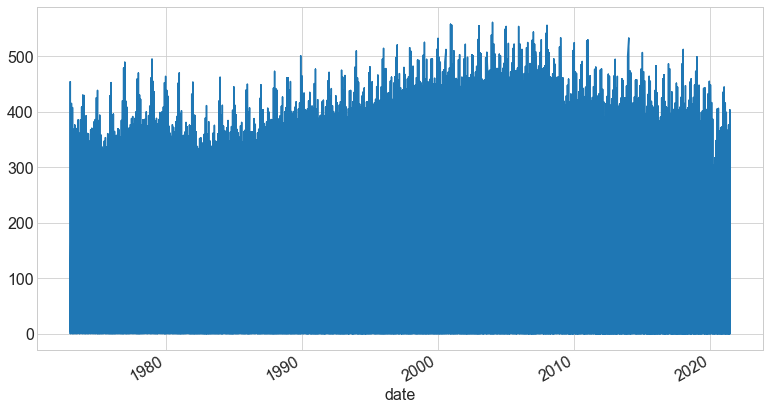

In [24]:
# using a .plot() on the co2 column
df.co2.plot()

(array([5221., 1124.,  539.,  667.,   15.,    6.,  130.,  215.,  182.,
          49.]),
 array([-2.050000e-01,  5.589240e+01,  1.119898e+02,  1.680872e+02,
         2.241846e+02,  2.802820e+02,  3.363794e+02,  3.924768e+02,
         4.485742e+02,  5.046716e+02,  5.607690e+02]),
 <BarContainer object of 10 artists>)

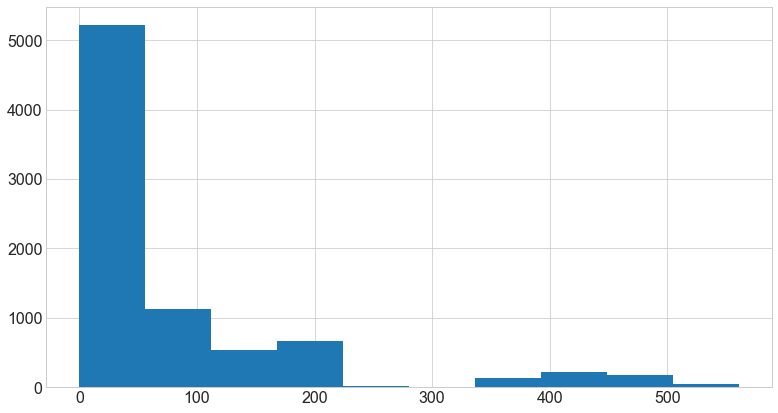

In [25]:
# making a histogram of the co2 column
plt.hist(df.co2)

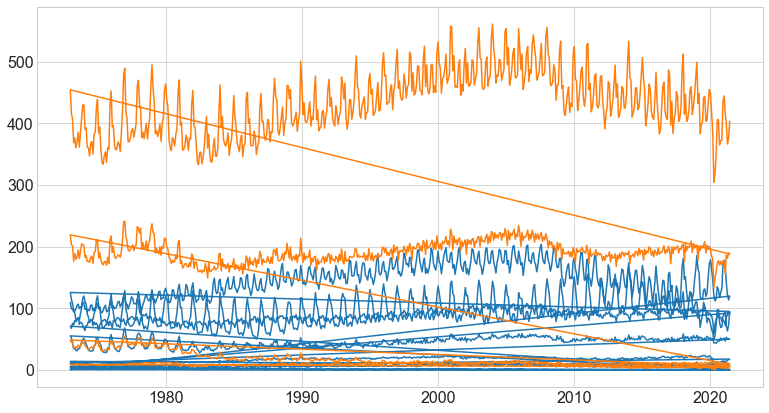

In [26]:
# Data Splitting
# Percentage based

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.co2)
plt.plot(test.index, test.co2)

# Visualizations

In [27]:
# We'll store our target in a variable named y for ease of access.
y = train.co2
y.head() # check_yo_head

date
1973-01-01    109.552
1973-02-01     98.833
1973-03-01     98.483
1973-04-01     94.150
1973-05-01     95.424
Name: co2, dtype: float64

<AxesSubplot:ylabel='Frequency'>

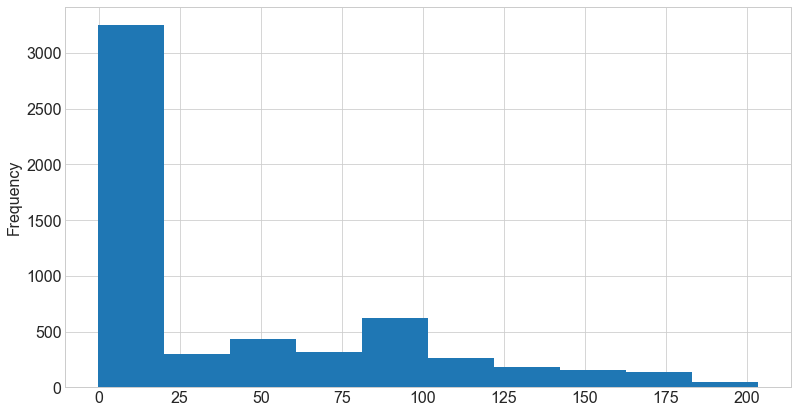

In [28]:
# make a histogram to show the distribution of our target variable
y.plot.hist()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

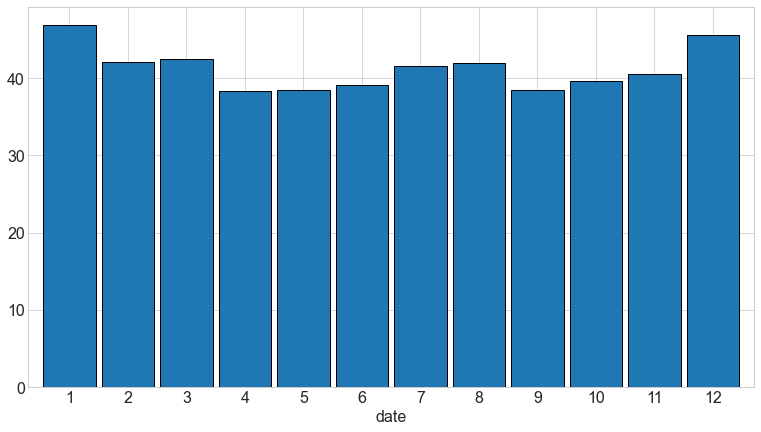

In [29]:
# treat components of the date as a seperate categorical feature.
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)

<AxesSubplot:xlabel='date'>

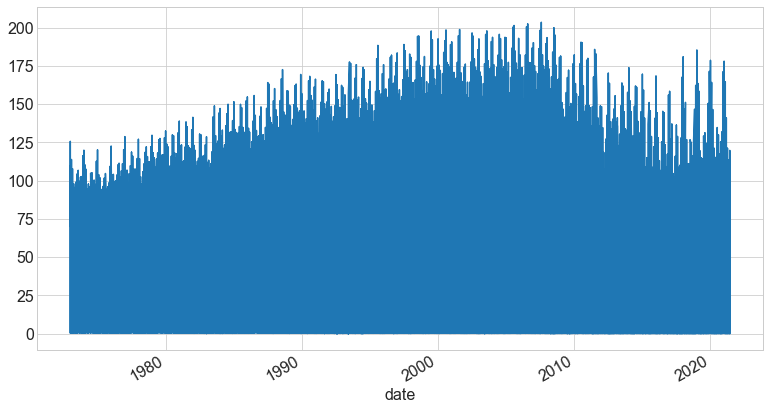

In [30]:
# Visualize the target over time
# This can be as simple as calling .plot on a dataframe or series with a datetime index.
y.plot()

<AxesSubplot:title={'center':'Monthly Average'}, xlabel='date'>

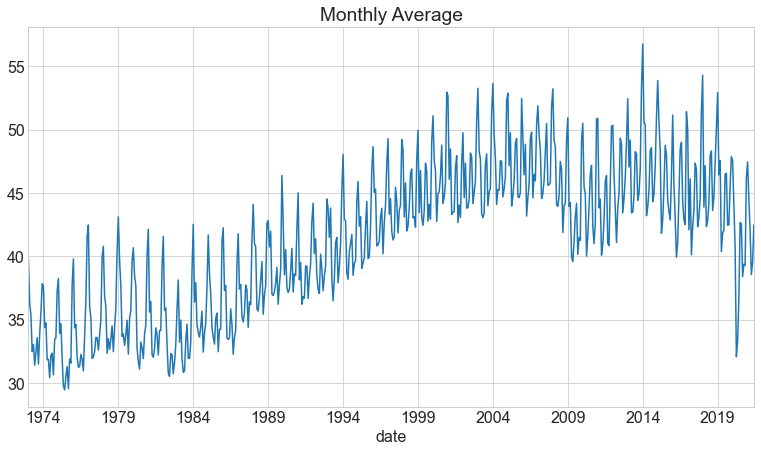

In [31]:
# resample our target and visualize it over various time periods.
y.resample('M').mean().plot(title='Monthly Average')

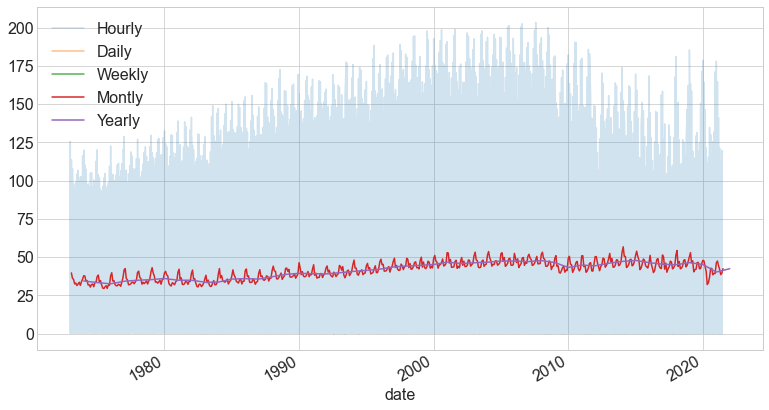

In [32]:
# combine visualizations to see how the aggregating smoothes out the data
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

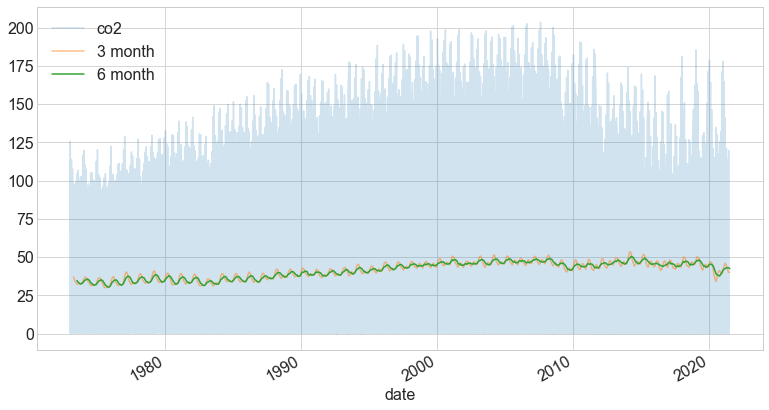

In [33]:
# In addition to resampling, we can calculate moving averages with the .rolling method
y.plot(alpha=.2)
y.resample('M').mean().rolling(3).mean().plot(alpha=.5, label='3 month')
y.resample('M').mean().rolling(6).mean().plot(alpha=8, label='6 month')
plt.legend()

<AxesSubplot:title={'center':'Average year to year change in co2'}, xlabel='date'>

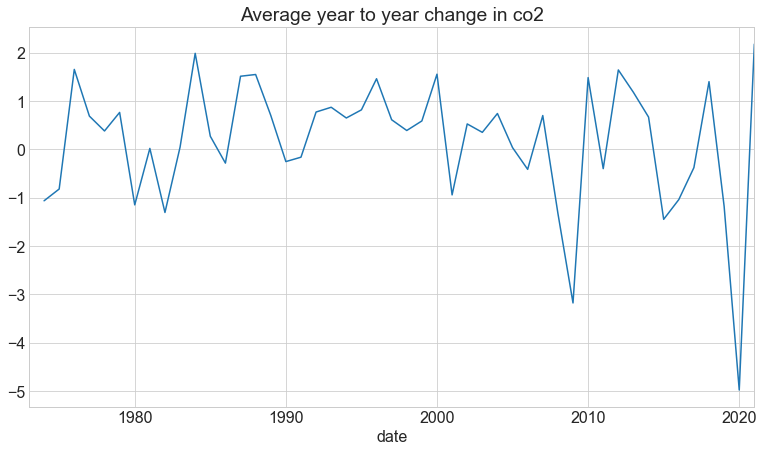

In [34]:
# We can use the .diff method to visualize the change in temperature from one time period to the next (year)
y.resample('Y').mean().diff().plot(title='Average year to year change in co2')

<AxesSubplot:title={'center':'Average month-to-month change in co2'}, xlabel='date'>

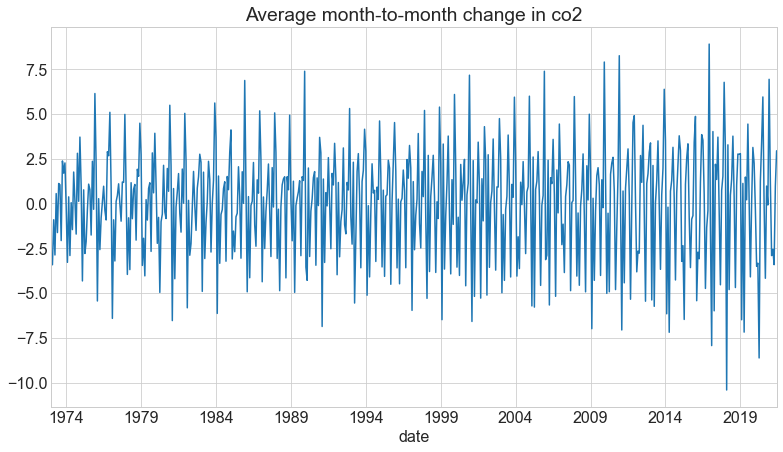

In [35]:
# We can use the .diff method to visualize the change in temperature from one time period to the next (month)
y.resample('M').mean().diff().plot(title='Average month-to-month change in co2')

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='date'>

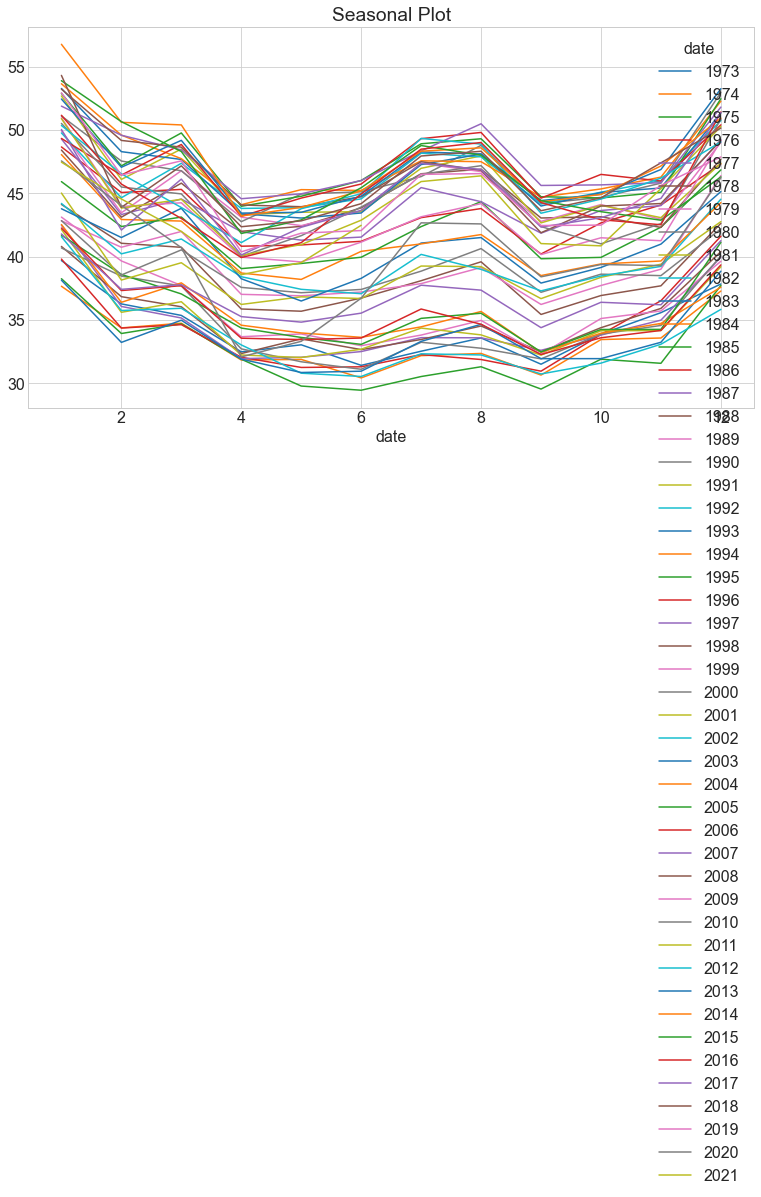

In [36]:
# seasonal plot
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

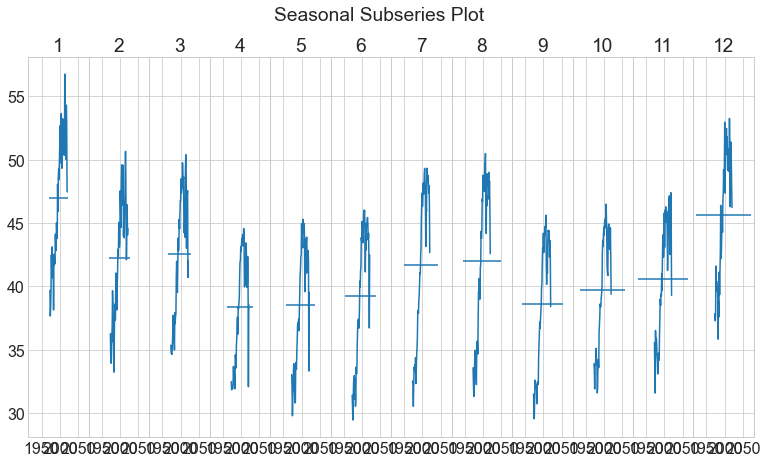

In [37]:
# A seasonal subseries plot shows the change year-over-year within each month.
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

Text(0.5, 1.0, 'Lag plot with lag=1')

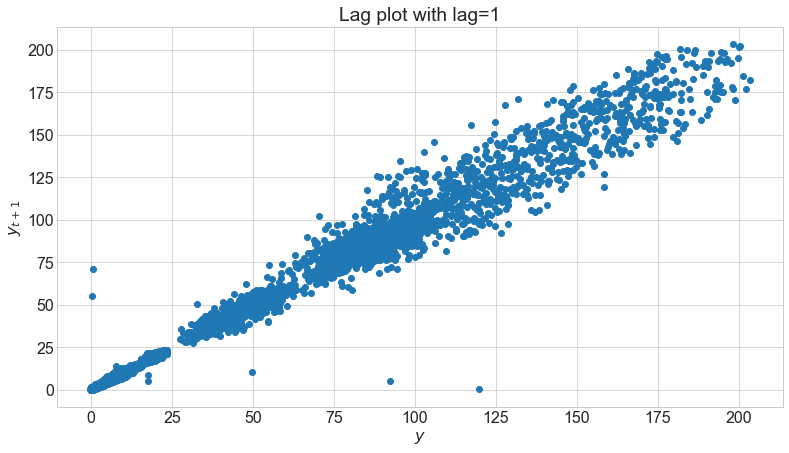

In [38]:
# lag plot
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

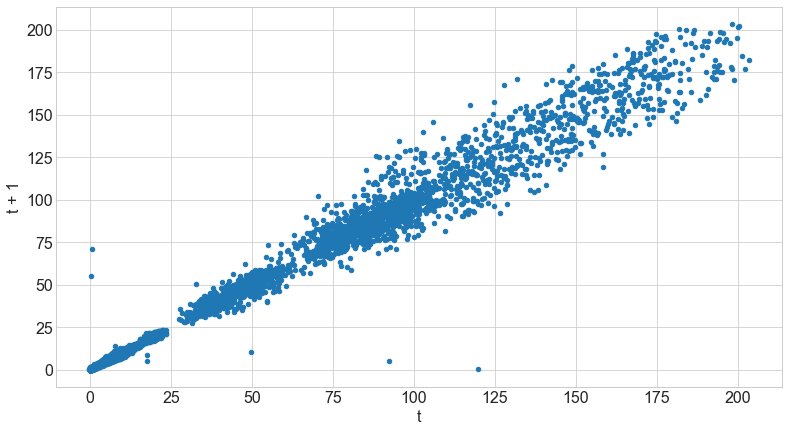

In [39]:
# lag plot
train['y(t + 1)'] = train.co2.shift(-1)
ax = train.plot.scatter(x='co2', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

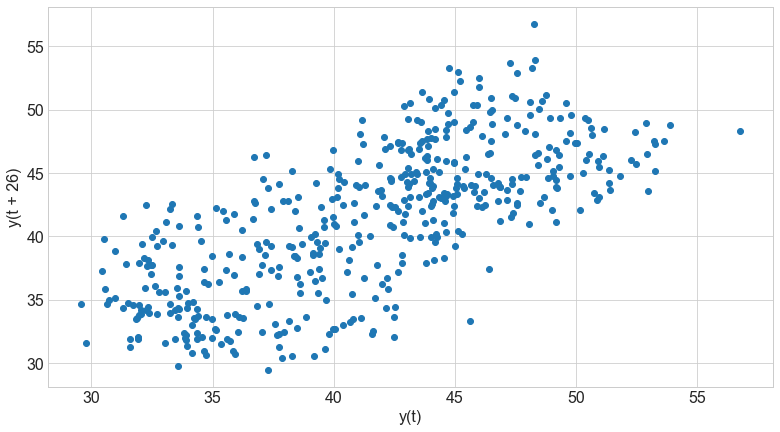

In [40]:
# lag plot with lag=26
pd.plotting.lag_plot(train.co2.resample('W').mean(), lag=26)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

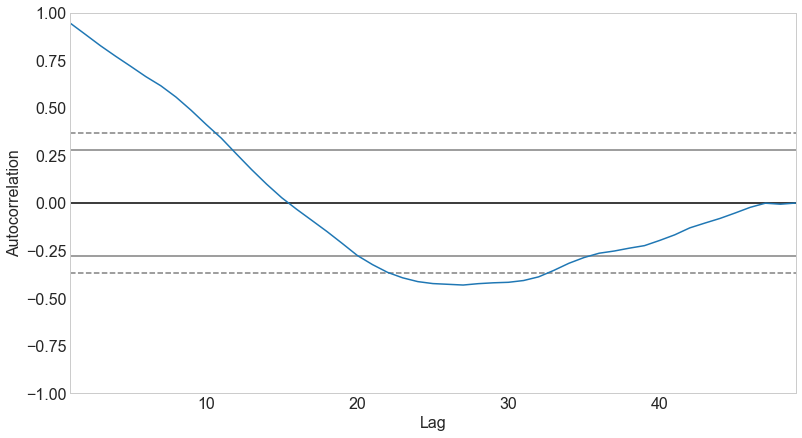

In [41]:
# Autocorrelation Plot year
pd.plotting.autocorrelation_plot(train.co2.resample('Y').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

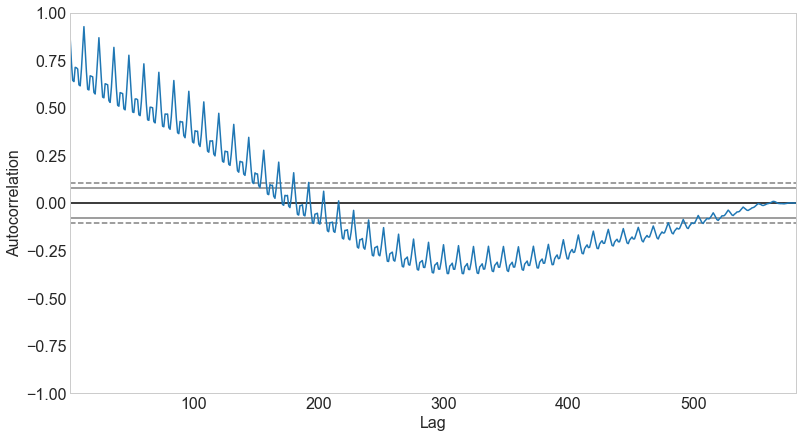

In [42]:
# Autocorrelation Plot month
pd.plotting.autocorrelation_plot(train.co2.resample('M').mean())

In [43]:
# Seasonal Decomposition
y = train.co2.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1973-01-31,39.6954,NaN,5.732656,NaN
1973-02-28,36.2739,NaN,0.860711,NaN
1973-03-31,35.3655,NaN,1.298602,NaN
1973-04-30,32.4913,NaN,-2.976994,NaN
1973-05-31,33.0453,NaN,-2.829228,NaN


<AxesSubplot:xlabel='date'>

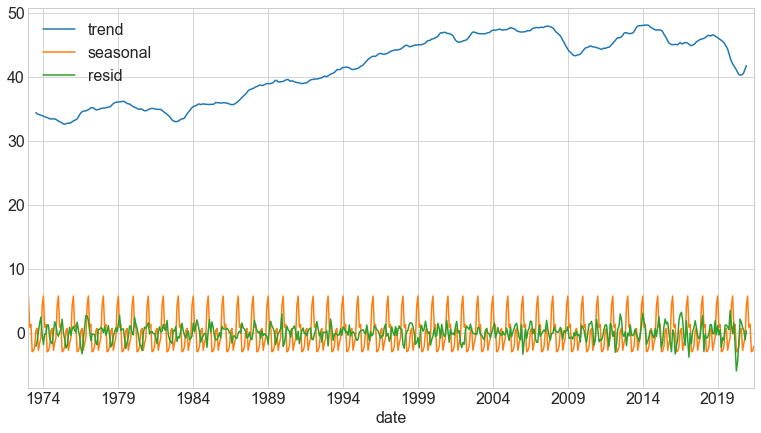

In [44]:
# Seasonal Decomposition
decomposition.iloc[:, 1:].plot()

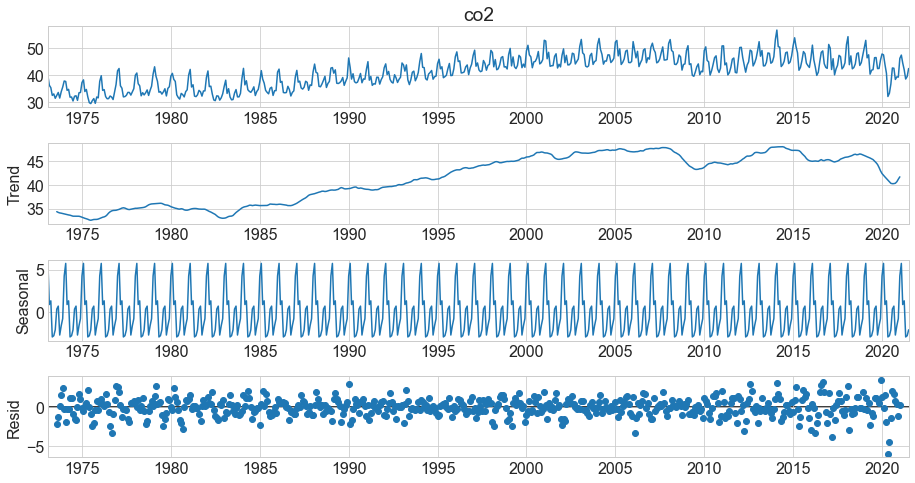

In [45]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

In [46]:
# Categories over time
train = train.resample('D').mean()
# create a categorical feature
train['co2_bin'] = pd.qcut(train.co2, 4, labels=['low', 'mid_1', 'mid_2', 'high'])
train.groupby('co2_bin').mean()

,co2,y(t + 1)
co2_bin,,
low,33.511501,34.111737
mid_1,39.506069,39.847694
mid_2,43.786659,44.376036
high,48.595594,47.017569


Text(0, 0.5, '% of days in the month')

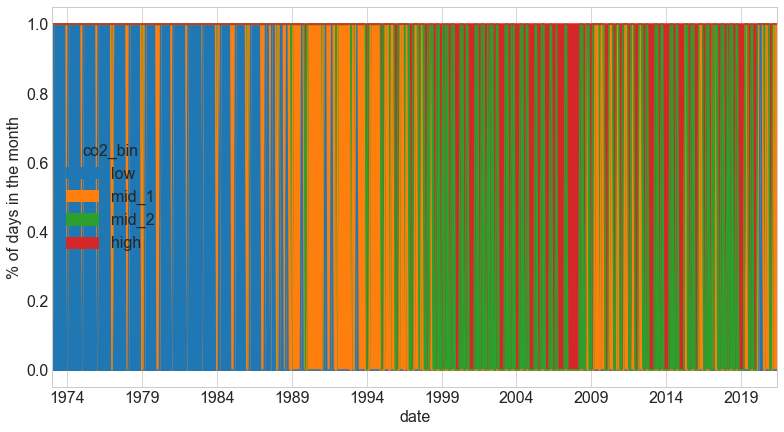

In [47]:
# How is the distribution of co2_bin changing over time?
(train.groupby('co2_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

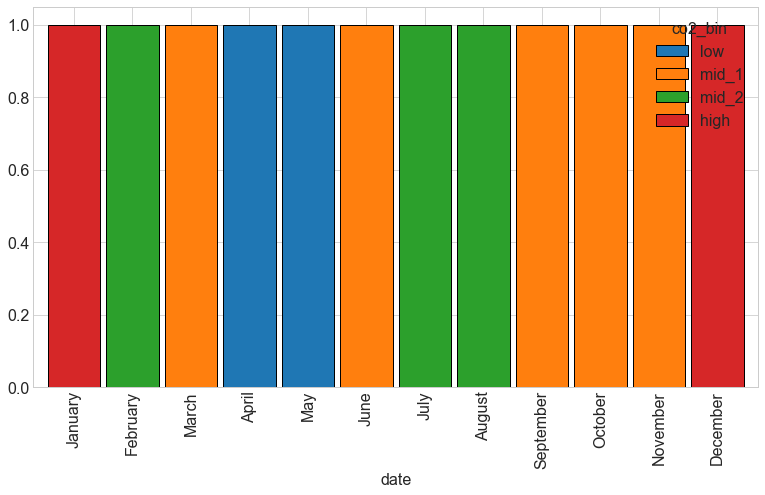

In [48]:
ax = (train['2020']
 .groupby('co2_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

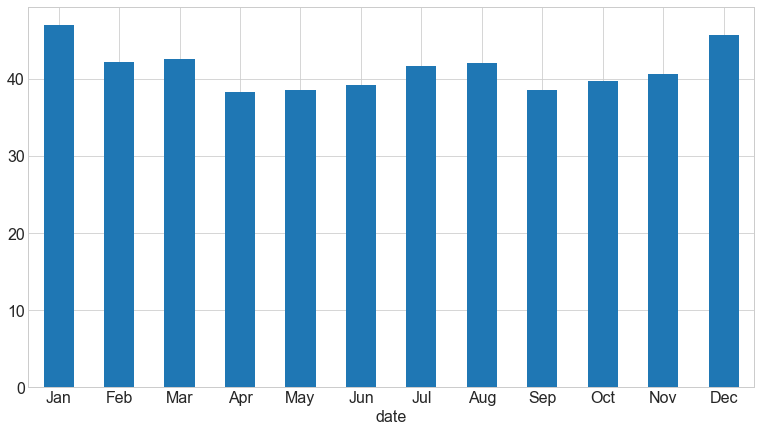

In [49]:
# strftime
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

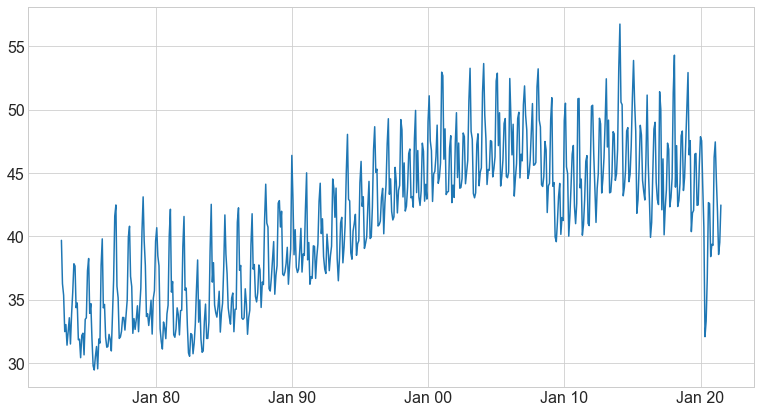

In [50]:
# Matplotlib Dates
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('M').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

##  Explore / Visuals Takeaways:
- 1
- 2
- 3

# Modeling

In [51]:
# checking the size of the data using len() function
df_size = len(df)
df_size

8148

In [52]:
# looking a half of the data .5
len(df) * .5

4074.0

In [53]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [54]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [55]:
# sum of train, validate and test = total number of rows? 
print(len(train) + len(validate) + len(test) == len(df))

True


In [56]:
# test the row starts
print(df.head(1) == train.head(1))

             co2
date            
1973-01-01  True


In [57]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,co2
date,
1982-08-01,8.264
1982-09-01,5.836


In [58]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,co2
date,
2021-06-01,403.179
2021-06-01,403.179


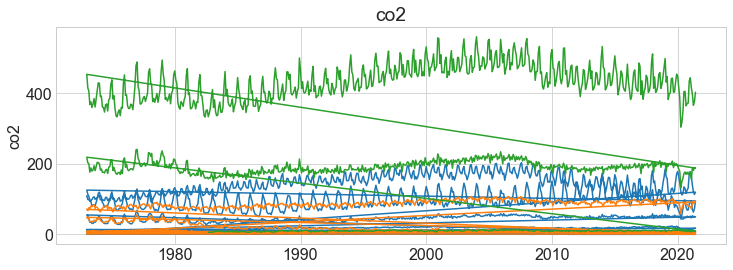

In [59]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [60]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values and compute the 
    mean squared error and then take the square root and round to zero decimals
    it will return the rmse 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [61]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    
    plt.show()

In [62]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [63]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [64]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the mode_type as a string, the target variable as a string
    and rund the evaluate() function to compute the rmse,
    and append the dataframe a row with the model_type, target_var, and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# last observed value

In [65]:
# make predictions
# taking the last observation
last_co2 = train['co2'][-1:][0]
last_co2

0.003

In [66]:
# make predictions
yhat_df = pd.DataFrame({'co2': [last_co2]}, 
                       index = validate.index)

yhat_df.head(2)

,co2
date,
1973-01-01,0.003
1973-02-01,0.003


co2 -- RMSE: 44


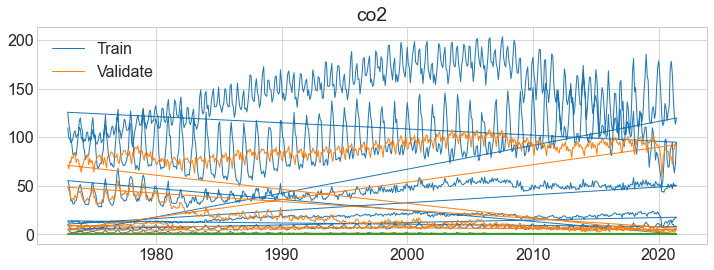

In [67]:
for col in train.columns:
    plot_and_eval(col)

In [68]:
df.tail()

,co2
date,
2021-02-01,415.513
2021-03-01,398.802
2021-04-01,366.332
2021-05-01,376.347
2021-06-01,403.179


In [69]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [70]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,44.0


In [71]:
# Simple Average
# make predictions
avg_co2 = round(train['co2'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'co2': [avg_co2]}, 
                       index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [72]:
yhat_df.head() # check_yo_head

,co2
date,
1973-01-01,44.48
1973-02-01,44.48
1973-03-01,44.48
1973-04-01,44.48
1973-05-01,44.48


co2 -- RMSE: 39


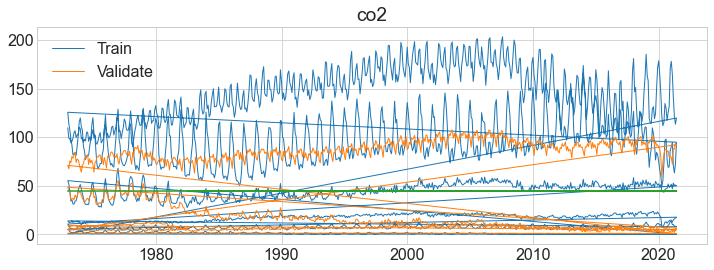

In [73]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [74]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [75]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,44.0
1,simple_average,co2,39.0


In [76]:
# compute a 30 day rolling average,
# use the most recent/last 30 day period value to predict forward.
period = 30

avg_co2 = round(train['co2'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,co2
date,
1973-01-01,0.09
1973-02-01,0.09
1973-03-01,0.09


co2 -- RMSE: 44


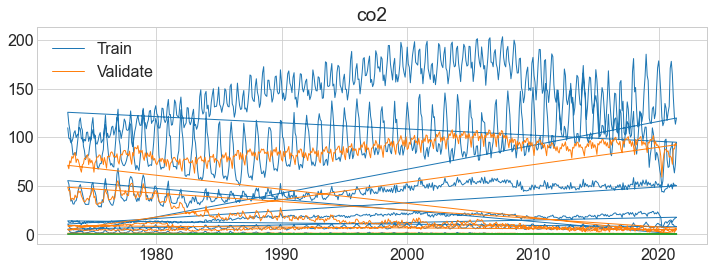

In [77]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [78]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [79]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,44.0
1,simple_average,co2,39.0
2,30d moving average,co2,44.0


In [80]:
# Let's try out several other values for periods

periods = [1, 60, 90, 120, 150]

for p in periods:
    avg_co2 = round(train['co2'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'co2'
                            )

In [81]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,44.0
1,simple_average,co2,39.0
2,30d moving average,co2,44.0
3,1d moving average,co2,44.0
4,60d moving average,co2,44.0
5,90d moving average,co2,44.0
6,120d moving average,co2,44.0
7,150d moving average,co2,44.0


In [82]:
# Which is best so far?
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_amount

39.0

In [83]:
# evaluation metrics on eval_df
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
1,simple_average,co2,39.0


In [84]:
# setting up for plots
plt.rc('figure', figsize=(12, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

In [85]:
# holt's linear trend model. 
from statsmodels.tsa.api import Holt

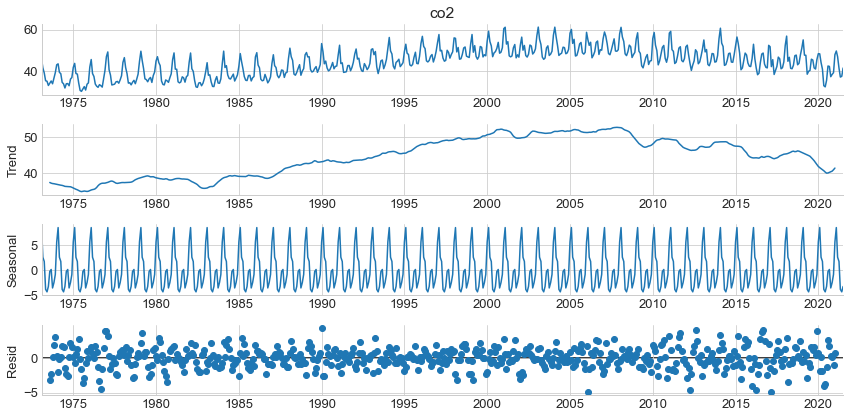

In [86]:
# Holt's Linear Trend
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['co2'].resample('M').mean()).plot()
plt.show()

In [87]:

model = Holt(train['co2'], exponential = False)
model = model.fit(smoothing_level = .1, 
                    smoothing_slope = .1, 
                    optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                            end = validate.index[-1])

yhat_df['co2'] = yhat_items

In [88]:
yhat_df

,co2
date,
1973-01-01,98.833000
1973-02-01,89.293090
1973-03-01,79.730670
1973-04-01,71.277015
1973-05-01,63.464156
...,...
1982-04-01,128.182972
1982-05-01,126.439582
1982-06-01,125.017055


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

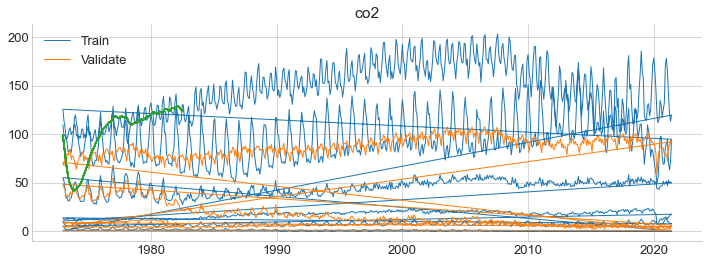

In [89]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [90]:
# plot_and_eval('co2')

In [91]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [92]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,44.0
1,simple_average,co2,39.0
2,30d moving average,co2,44.0
3,1d moving average,co2,44.0
4,60d moving average,co2,44.0
5,90d moving average,co2,44.0
6,120d moving average,co2,44.0
7,150d moving average,co2,44.0


In [93]:
df.head()

,co2
date,
1973-01-01,109.552
1973-02-01,98.833
1973-03-01,98.483
1973-04-01,94.150
1973-05-01,95.424


Getting the data again to split for predict based on previous cycle

In [ ]:
df = pd.read_csv('us_monthly_co2_data.csv')
df = df[df.YYYYMM.astype(str).str[-2:] != '13']
df = df.drop(['MSN', 'Column_Order', 'Description', 'Unit'], axis = 1)
df.rename(columns={'YYYYMM':'date', 'Value':'co2'}, inplace=True)
#df.date = df.date.astype(str)
#df.date = df.date.apply(lambda x: x[:4] + "-" + x[4:] + "-" + '01')
#df.date = pd.to_datetime(df.date)
#df['year'] = df.date.dt.year

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
# Predict Based on Previous Cycle

# re-split the data
train = df[:'2018']
validate = df[('2019')]
test = df[('2020')]

In [ ]:
yhat_df = train['2018'] + train.diff(30).mean()

In [ ]:
pd.concat([yhat_df.head(1), validate.head(1)])

In [ ]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

In [ ]:
yhat_df

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

# Conclusion:
- Which model did the best?

In [94]:
# get the min rmse for each variable
min_rmse_co2 = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_co2)
        )]

,model_type,target_var,rmse
1,simple_average,co2,39.0


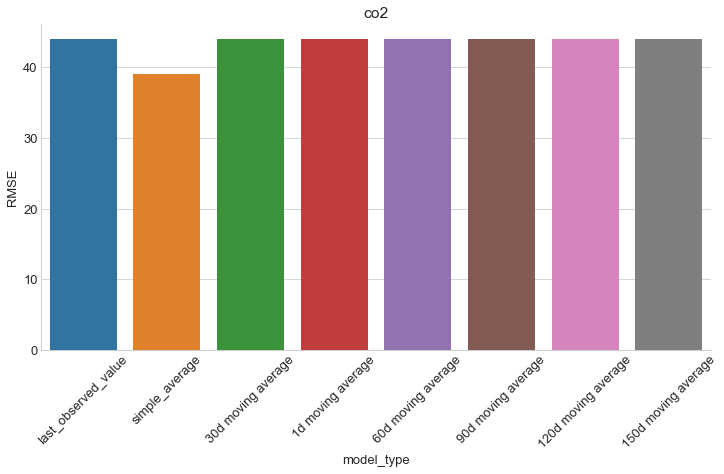

In [95]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

### Let's test it out on our out-of-sample data

### We will be using train + validate to predict test.

In [96]:
yhat_df = validate + train.diff(1).mean()
yhat_df.index = test.index

ValueError: Length mismatch: Expected axis has 2444 elements, new values have 1630 elements

In [97]:
rmse_co2 = round(sqrt(mean_squared_error(test['co2'], yhat_df['co2'])), 0)

ValueError: Found input variables with inconsistent numbers of samples: [1630, 2444]

In [98]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

In [99]:
print("rmse - co2: ", rmse_co2)

for col in train.columns:
    plot_and_eval(col)

NameError: name 'rmse_co2' is not defined